### setup

In [48]:
from FireSimulator import *

import copy
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import sys
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### function to visualize forest

In [2]:
def visualize_forest(axis_handle, data):
    r, c = data.shape
    for i in range(r):
        for j in range(c):
            x = col_to_x(j)
            y = row_to_y(r,i)
            
            rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6)
            
            if data[i,j] == 0:
                rect.set_color('g')
            elif data[i,j] == 1:
                rect.set_color('r')
            elif data[i,j] == 2:
                rect.set_color('k')
                
            axis_handle.add_patch(rect)
    
    return axis_handle

### simulation parameters

In [3]:
grid_size = 25
dp = 0
alpha = 0.2763
beta = np.exp(-0.1)

nn = [(-1,0),(1,0),(0,-1),(0,1)]

# pre-calculate the neighbor indices for each node
neighbors = {}
for i in range(grid_size):
    for j in range(grid_size):
        neighbors[(i,j)] = []
        
        for (di,dj) in nn:
            ii = i + di
            jj = j + dj
            if ii>=0 and ii<grid_size and jj>=0 and jj<grid_size:
                neighbors[(i,j)].append((ii,jj))

### dynamics

In [4]:
# States: 0-healthy, 1-fire, 2-burnt
def dynamics(xi_tm1, fi_tm1, xi_t):
    if xi_tm1 == 0:
        if xi_t == 0:
            return alpha**fi_tm1
        elif xi_t == 1:
            return 1-alpha**fi_tm1
        elif xi_t == 2:
            return 0
        
    elif xi_tm1 == 1:
        if xi_t == 0:
            return 0
        elif xi_t == 1:
            return beta
        elif xi_t == 2:
            return 1-beta
        
    elif xi_tm1 == 2:
        if xi_t == 0:
            return 0
        elif xi_t == 1:
            return 0
        elif xi_t == 2:
            return 1

### first case: measurement model $p(y^{t}_{t} ~|~ x^{t}_{i})$ i.e. point-to-point

In [5]:
meas_right = 0.9
meas_wrong = 0.5*(1-meas_right)
def measurement(xi_t, yi_t):
    if xi_t != yi_t:
        return meas_wrong
    elif xi_t == yi_t:
        return meas_right

### helper function to calculate a linear approximation to the log function

In [6]:
# piecewise linear approximation to log using 6 segments with regions hard-coded
def log_linear(x):
    
    if x >= 0.20318:
        value = 2*(x-1)
    elif x < 0.20318 and x >= 0.05:
        m = (np.log(0.20318) - np.log(0.05))/(0.20318 - 0.05)
        b = np.log(0.05) - m*0.05
        value = m*x + b
    elif x < 0.05 and x >= 0.01:
        m = (np.log(0.05) - np.log(0.01))/(0.05 - 0.01)
        b = np.log(0.01) - m*0.01
        value = m*x + b
    elif x < 0.01 and x >= 0.001:
        m = (np.log(0.01) - np.log(0.001))/(0.01 - 0.001)
        b = np.log(0.001) - m*0.001
        value = m*x + b
    elif x < 0.001 and x >= 1e-10:
        m = (np.log(0.001) - np.log(1e-10))/(0.001 - 1e-10)
        b = np.log(1e-10) - m*1e-10
        value = m*x + b
    else:
        value = -1.0*np.inf
    
    return value

In [14]:
# a simple linear approximation to log of the form C*(x-1)
def log_simple(x,C):
    value = C*(x-1)
    if x < np.exp(value):
        return -1.0*np.inf
    else:
        return value

### message-passing algorithm based on variational inference

In [44]:
def variational_method(prior, neighbors, grid_size, meas_data, Kmax=1, C=None):
    # initiliaze posterior to same size as prior
    post = np.zeros_like(prior)
    #post[:,:,0] = 0.34
    #post[:,:,1] = 0.33
    #post[:,:,2] = 0.33
    
    # simplify the prior distribution to two states,
    # 'not on fire' [0] and 'on fire' [1]
    prior_simple = np.zeros((grid_size,grid_size,2))
    prior_simple[:,:,1] = prior[:,:,1]
    prior_simple[:,:,0] = 1 - prior_simple[:,:,1]
    
    # initialize a structure to hold data for each node
    node_data = {}
    timing = {}
    for i in range(grid_size):
        for j in range(grid_size):
            node_data[(i,j)] = {}
            timing[(i,j)] = []
            
            node_data[(i,j)]['prior_simple'] = [0,0,0,0,0]
            # node_data[(i,j)]['post_simple'] = [0,0,0,0,0]
            node_data[(i,j)]['post_next'] = [0,0,0]
            
            node_data[(i,j)]['msg'] = {}
            node_data[(i,j)]['msg_simple'] = {}
            node_data[(i,j)]['msg_hat'] = {}
            node_data[(i,j)]['msg_next'] = {}
            
            # calculate the joint probability distribution over neighbors for each node,
            # the probability that f neighbors are on fire
            tic = time.clock()
            num_neighbors = len(neighbors[(i,j)])
            for l in range(2**num_neighbors):
                xj = np.base_repr(l, base=2).zfill(num_neighbors)

                f = xj.count('1')

                # need to be careful to avoid multiplying small numbers
                p = 0
                for m in range(num_neighbors):
                    nghbr = neighbors[(i,j)][m]
                    prob = prior_simple[nghbr[0],nghbr[1],int(xj[m])]
                    if prob < 5e-5:
                        p = -50
                        break
                    else:
                        p += np.log(prob)
                    
                if p <= -50:
                    node_data[(i,j)]['prior_simple'][f] += 0
                else:
                    node_data[(i,j)]['prior_simple'][f] += np.exp(p)
            toc = time.clock()
            timing[(i,j)].append(toc-tic)
    
    # main loop for message-passing
    for iteration in range(Kmax):
        
        # iterate through nodes (here, trees in a forest)
        for i in range(grid_size):
            for j in range(grid_size):

                # initialization step
                if iteration == 0:
                    tic = time.clock()
                    
                    # first calculate a preliminary message,
                    # a function of xi_(t-1) and xi_t 
                    for xi_tm1 in range(3):
                        for xi_t in range(3):
                            node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)] = 0
                            for fi_tm1 in range(5):
                                node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)] += \
                                    dynamics(xi_tm1, fi_tm1, xi_t)*node_data[(i,j)]['prior_simple'][fi_tm1]
                    
                    # calculate the node posterior by summing out xi_(t-1) from the preliminary message
                    qi_dist = [0,0,0]
                    for xi_t in range(3):
                        for xi_tm1 in range(3):
                            qi_dist[xi_t] += prior[i,j,xi_tm1]*node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)]
                        
                        # qi_dist[xi_t] = C*measurement(xi_t, meas_data[i,j])*qi_dist[xi_t]
                        if C is not None:
                            qi_dist[xi_t] = log_simple(measurement(xi_t, meas_data[i,j])*qi_dist[xi_t], C)
                        else:
                            qi_dist[xi_t] = log_linear(measurement(xi_t, meas_data[i,j])*qi_dist[xi_t])
                    
                    # normalize distribution
                    qi_dist = [el-max(qi_dist) for el in qi_dist]
                    normalization = 0
                    for idx,el in enumerate(qi_dist):
                        if el < -50:
                            qi_dist[idx] = 0
                            continue

                        qi_dist[idx] = np.exp(el)
                        normalization += qi_dist[idx]

                    # store posterior
                    #node_data[(i,j)]['post_next'] /= sum(node_data[(i,j)]['post_next']) 
                    node_data[(i,j)]['post_next'] = qi_dist / normalization
                    
                    # skip calculating the shared message if only one algorithm iteration
                    if Kmax == 1:
                        toc = time.clock()
                        timing[(i,j)].append(toc-tic)
                        continue
                    
                    # calculate message that will be shared by summing out xi_t from the preliminary message
                    for xi_tm1 in range(3):
                        node_data[(i,j)]['msg_next'][xi_tm1] = 0  
                        for xi_t in range(3):
                            node_data[(i,j)]['msg_next'][xi_tm1] += \
                                node_data[(i,j)]['post_next'][xi_t]*node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)]
                    
                    # normalize message
                    msg_normalization = sum(node_data[(i,j)]['msg_next'].values())
                    for key in node_data[(i,j)]['msg_next'].keys():
                        node_data[(i,j)]['msg_next'][key] /= msg_normalization
                        
                    toc = time.clock()
                    timing[(i,j)].append(toc-tic)
                    
                else:
                    tic = time.clock()
                    
                    num_neighbors = len(neighbors[(i,j)])
                    for idx in range(5):
                        node_data[(i,j)]['msg_simple'][idx] = 0
                    
                    # use the shared message from neighbors to construct a joint probability distribution,
                    # a joint message based on number of neighbors on fire
                    for l in range(2**num_neighbors):
                        xj = np.base_repr(l, base=2).zfill(num_neighbors)

                        fi_tm1 = xj.count('1')
                        #node_data[(i,j)]['msg_simple'].setdefault(fi_tm1, 0)

                        # avoid multiplying small numbers by using log and exp
                        p = 0
                        for m in range(num_neighbors):
                            nghbr = neighbors[(i,j)][m]
                            if int(xj[m]) == 0:
                                prob = (node_data[(nghbr[0],nghbr[1])]['msg'][0] + \
                                        node_data[(nghbr[0],nghbr[1])]['msg'][2])
                            elif int(xj[m]) == 1:
                                prob = node_data[(nghbr[0],nghbr[1])]['msg'][1]
                                
                            if prob < 1e-10:
                                p = -50
                                break
                            else:
                                p += np.log(prob)
                            
                        if p <= -50:
                            node_data[(i,j)]['msg_simple'][fi_tm1] += 0
                        else:
                            node_data[(i,j)]['msg_simple'][fi_tm1] += np.exp(p)
                    
                    # use the joint message distribution to calculate a preliminary message,
                    # a function of xi_(t-1) and xi_t
                    for xi_tm1 in range(3):
                        for xi_t in range(3):
                            node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)] = 0
                            for fi_tm1 in range(5):
                                node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)] += \
                                    dynamics(xi_tm1, fi_tm1, xi_t)*node_data[(i,j)]['prior_simple'][fi_tm1]* \
                                    node_data[(i,j)]['msg_simple'][fi_tm1]      
                    
                    # calculate the node posterior by summing out xi_(t-1) from the preliminary message
                    qi_dist = [0,0,0]
                    for xi_t in range(3):
                        for xi_tm1 in range(3):
                            qi_dist[xi_t] += prior[i,j,xi_tm1]*node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)]

                        # qi_dist[xi_t] = C*measurement(xi_t, meas_data[i,j])*qi_dist[xi_t]
                        if C is not None:
                            qi_dist[xi_t] = log_simple(measurement(xi_t, meas_data[i,j])*qi_dist[xi_t], C)
                        else:
                            qi_dist[xi_t] = log_linear(measurement(xi_t, meas_data[i,j])*qi_dist[xi_t])
                    
                    # normalize and store distribution
                    qi_dist = [el-max(qi_dist) for el in qi_dist]
                    normalization = 0
                    for idx,el in enumerate(qi_dist):
                        if el < -50:
                            qi_dist[idx] = 0 
                            continue
                        
                        qi_dist[idx] = np.exp(el)
                        normalization += qi_dist[idx]
                        
                    node_data[(i,j)]['post_next'] = qi_dist / normalization
                    
                    # calculate next message by summing out xi_t from the preliminary message
                    for xi_tm1 in range(3):
                        node_data[(i,j)]['msg_next'][xi_tm1] = 0  
                        for xi_t in range(3):
                            node_data[(i,j)]['msg_next'][xi_tm1] += node_data[(i,j)]['post_next'][xi_t]*\
                                node_data[(i,j)]['msg_hat'][(xi_tm1,xi_t)]
                    
                    # normalize message
                    msg_normalization = sum(node_data[(i,j)]['msg_next'].values())
                    for key in node_data[(i,j)]['msg_next'].keys():
                        node_data[(i,j)]['msg_next'][key] /= msg_normalization
                        
                    toc = time.clock()
                    timing[(i,j)].append(toc-tic)
         
        # update posterior for each node and reset some stored data
        for i in range(grid_size):
            for j in range(grid_size):
                node_data[(i,j)]['msg'] = copy.copy(node_data[(i,j)]['msg_next'])
                
                post[i,j,:] = copy.copy(node_data[(i,j)]['post_next'])
                
                node_data[(i,j)]['msg_simple'] = {}
                node_data[(i,j)]['msg_hat'] = {}
                node_data[(i,j)]['msg_next'] = {}
                node_data[(i,j)]['post_next'] = [0,0,0]

    for i in range(grid_size):
        for j in range(grid_size):
            if len(timing[(i,j)]) >= 3:
                timing[(i,j)] = sum(timing[(i,j)][0:2]) + sum(timing[(i,j)][2:])/(Kmax-1)
            else:
                timing[(i,j)] = sum(timing[(i,j)])
                
    timing = sum(timing.values())/grid_size**2
    
    return post, timing

### run a simulation

In [60]:
np.random.seed(1000)

# fire_init = [(int(grid_size/2)+1,int(grid_size/2)+1)]
# sim = FireSimulator(grid_size, alpha=alpha, beta=beta, fire_init=fire_init)

sim = FireSimulator(grid_size, alpha=alpha, beta=beta)
sim.step([], dbeta=dp)

belief = np.zeros((grid_size,grid_size,3))
idx = np.where(sim.state==0)
belief[idx[0],idx[1],:] = [1,0,0]
idx = np.where(sim.state==1)
belief[idx[0],idx[1],:] = [0,1,0]
idx = np.where(sim.state==2)
belief[idx[0],idx[1],:] = [0,0,1]

meas_data = sim.state
state_est = np.argmax(belief, axis=2) 
meas_errors = []
state_errors = []

total_time = []

plotting = False

if plotting:
    fig = plt.figure(figsize=(15,15))

    ax1 = fig.add_subplot(131, aspect='equal')
    ax1.set_xlim([0,grid_size+1])
    ax1.set_ylim([0,grid_size+1])
    plt.title('ground truth\nt = %d' %sim.iter)
    plt.tick_params(axis='both', which='both', 
                    labelbottom=False, labelleft=False, bottom=False, left=False)
    ax1 = visualize_forest(ax1, sim.state)

    ax2 = fig.add_subplot(132, aspect='equal')
    ax2.set_xlim([0,grid_size+1])
    ax2.set_ylim([0,grid_size+1])
    plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_data!=sim.state),sim.iter))
    plt.tick_params(axis='both', which='both', 
                    labelbottom=False, labelleft=False, bottom=False, left=False)
    ax2 = visualize_forest(ax2, meas_data)

    ax3 = fig.add_subplot(133, aspect='equal')
    ax3.set_xlim([0,grid_size+1])
    ax3.set_ylim([0,grid_size+1])
    plt.tick_params(axis='both', which='both', 
                    labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est!=sim.state),sim.iter))
    ax3 = visualize_forest(ax3, state_est)
    
    rows, cols = np.where(state_est != sim.state)
    for i, j in zip(rows, cols):
        x = col_to_x(j)
        y = row_to_y(grid_size, i)
        plt.plot(x, y, marker='o', color='b')

tic = time.clock()
# for _ in range(50):
while not sim.end:
    
    sim.step([], dbeta=dp)
    
    meas_data = np.zeros_like(sim.state) + -1
    for i in range(grid_size):
        for j in range(grid_size):
            
            meas = sim.state[i,j]
            p_list = [meas_wrong,meas_wrong,meas_wrong]
            p_list[meas] += meas_right - meas_wrong
            meas_data[i,j] = np.random.choice([0,1,2], p=p_list)
    
    # algorithm parameters:
    #   Kmax - number of message passing iterations
    #   C - linear approximation constant. C=None uses a piecewise linear approximation
    belief, t = variational_method(belief, neighbors, grid_size, meas_data, Kmax=1, C=None)
    total_time.append(t)
    state_est = np.argmax(belief, axis=2)
    
    num_errors = np.sum(state_est != sim.state)
    state_errors.append(num_errors)
    meas_errors.append(np.sum(meas_data != sim.state))
    #print('iteration %03d: %d errors' %(sim.iter,num_errors))
    
    if plotting:
        fig = plt.figure(figsize=(15,15))

        ax1 = fig.add_subplot(131, aspect='equal')
        ax1.set_xlim([0,grid_size+1])
        ax1.set_ylim([0,grid_size+1])
        plt.title('ground truth\nt = %d' %sim.iter)
        plt.tick_params(axis='both', which='both', 
                        labelbottom=False, labelleft=False, bottom=False, left=False)
        ax1 = visualize_forest(ax1, sim.state)

        ax2 = fig.add_subplot(132, aspect='equal')
        ax2.set_xlim([0,grid_size+1])
        ax2.set_ylim([0,grid_size+1])
        plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_data!=sim.state),sim.iter))
        plt.tick_params(axis='both', which='both', 
                        labelbottom=False, labelleft=False, bottom=False, left=False)
        ax2 = visualize_forest(ax2, meas_data)

        ax3 = fig.add_subplot(133, aspect='equal')
        ax3.set_xlim([0,grid_size+1])
        ax3.set_ylim([0,grid_size+1])
        plt.tick_params(axis='both', which='both', 
                        labelbottom=False, labelleft=False, bottom=False, left=False)
        plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est!=sim.state),sim.iter))
        ax3 = visualize_forest(ax3, state_est)

        rows, cols = np.where(state_est != sim.state)
        for i, j in zip(rows, cols):
            x = col_to_x(j)
            y = row_to_y(grid_size, i)
            plt.plot(x, y, marker='o', color='b')
            
    # print('sim iteration:',sim.iter)
    
toc = time.clock()
print('number of sim iterations:',sim.iter)
print('median error: %0.3f%%' %(np.median(state_errors)*100/grid_size**2))
print('mean error: %0.3f%%' %(np.mean(state_errors)*100/grid_size**2))
print('max error: %0.3f%%' %(np.amax(state_errors)*100/grid_size**2))
print('min error: %0.3f%%' %(np.amin(state_errors)*100/grid_size**2))
print('time per node per iteration: %0.3fms' %(1000*sum(total_time)/len(total_time)))
print('%0.2fs = %0.2fm elapsed' % (toc-tic,(toc-tic)/60))

number of sim iterations: 85
median error: 0.960%
mean error: 1.850%
max error: 6.880%
min error: 0.160%
time per node per iteration: 0.401ms
62.02s = 1.03m elapsed


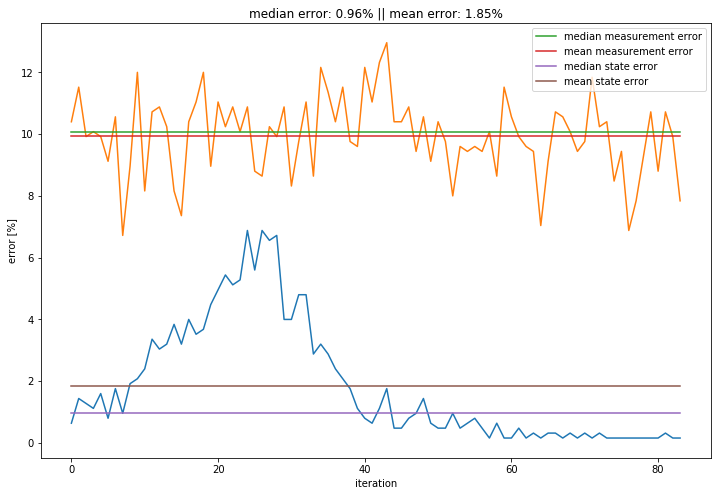

In [67]:
plot_state_errors = [100*e/grid_size**2 for e in state_errors]
plot_meas_errors = [100*e/grid_size**2 for e in meas_errors]

plt.figure(figsize=(12,8))
plt.plot(plot_state_errors)
plt.plot(plot_meas_errors)
plt.plot(range(len(plot_meas_errors)),np.median(plot_meas_errors)*np.ones(len(plot_meas_errors)), \
         label='median measurement error')
plt.plot(range(len(plot_meas_errors)),np.mean(plot_meas_errors)*np.ones(len(plot_meas_errors)), \
         label='mean measurement error')
plt.plot(range(len(plot_state_errors)),np.median(plot_state_errors)*np.ones(len(plot_state_errors)), \
         label='median state error')
plt.plot(range(len(plot_state_errors)),np.mean(plot_state_errors)*np.ones(len(plot_state_errors)), \
         label='mean state error')

plt.title('median error: %0.2f%% || mean error: %0.2f%%' \
          %(np.median(state_errors)*100/grid_size**2,np.mean(state_errors)*100/grid_size**2))
plt.ylabel('error [%]')
plt.xlabel('iteration')

plt.legend(loc=1)

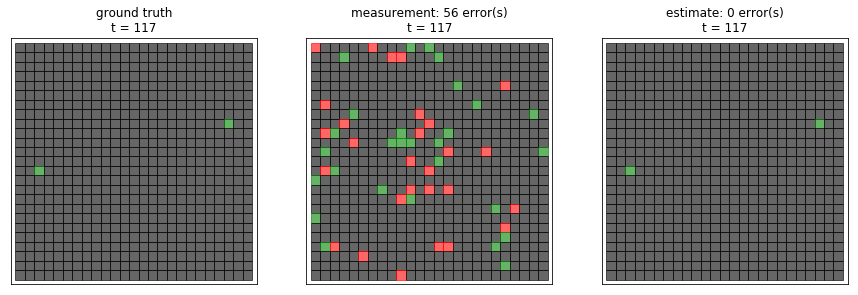

In [18]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(131, aspect='equal')
ax1.set_xlim([0,grid_size+1])
ax1.set_ylim([0,grid_size+1])
plt.title('ground truth\nt = %d' %sim.iter)
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax1 = visualize_forest(ax1, sim.state)

ax2 = fig.add_subplot(132, aspect='equal')
ax2.set_xlim([0,grid_size+1])
ax2.set_ylim([0,grid_size+1])
plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_data != sim.state),sim.iter))
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax2 = visualize_forest(ax2, meas_data)

ax3 = fig.add_subplot(133, aspect='equal')
ax3.set_xlim([0,grid_size+1])
ax3.set_ylim([0,grid_size+1])
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est != sim.state),sim.iter))
ax3 = visualize_forest(ax3, state_est)

### benchmark method using many simulations

In [36]:
grid_size = 2
Kparam = 2
results = {}

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' %st)

tic = time.clock()
for s_idx,s in enumerate(range(1000)):

    seed = s+1000
    np.random.seed(seed)
    results[seed] = {}
    results[seed]['state_error'] = []
    results[seed]['meas_error'] = []

    fire_init = [(int(grid_size/2)+1,int(grid_size/2)+1)]
    sim = FireSimulator(grid_size, alpha=alpha, beta=beta, fire_init=fire_init)

    #belief = np.zeros((grid_size,grid_size,3))
    #idx = np.where(sim.state==0)
    #belief[idx[0],idx[1],:] = [1,0,0]
    #idx = np.where(sim.state==1)
    #belief[idx[0],idx[1],:] = [0,1,0]
    #idx = np.where(sim.state==2)
    #belief[idx[0],idx[1],:] = [0,0,1]
    
    belief = 0.33*np.ones((grid_size,grid_size,3))

    while not sim.end:
        sim.step([], dbeta=dp)

        meas_data = np.zeros_like(sim.state) + -1
        for i in range(grid_size):
            for j in range(grid_size):

                meas = sim.state[i,j]
                p_list = [meas_wrong,meas_wrong,meas_wrong]
                p_list[meas] += meas_right - meas_wrong
                meas_data[i,j] = np.random.choice([0,1,2], p=p_list)

        belief = variational_method(belief, neighbors, grid_size, meas_data, Kmax=Kparam, C=100)
        state_est = np.argmax(belief, axis=2)

        results[seed]['state_error'].append(np.sum(state_est != sim.state))
        results[seed]['meas_error'].append(np.sum(meas_data != sim.state))
        
    if (s_idx+1) % 100 == 0:
        st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
        print('[%s] finished %d simulations' %(st,s_idx+1))

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' %st)
        
toc = time.clock()
print('%0.2fs = %0.2fm elapsed' % (toc-tic,(toc-tic)/60))

[2018-07-11 12:29:35] start
[2018-07-11 12:29:38] finished 100 simulations
[2018-07-11 12:29:40] finished 200 simulations
[2018-07-11 12:29:43] finished 300 simulations
[2018-07-11 12:29:45] finished 400 simulations
[2018-07-11 12:29:48] finished 500 simulations
[2018-07-11 12:29:51] finished 600 simulations
[2018-07-11 12:29:54] finished 700 simulations
[2018-07-11 12:29:56] finished 800 simulations
[2018-07-11 12:29:59] finished 900 simulations
[2018-07-11 12:30:01] finished 1000 simulations
[2018-07-11 12:30:01] finish
26.10s = 0.44m elapsed


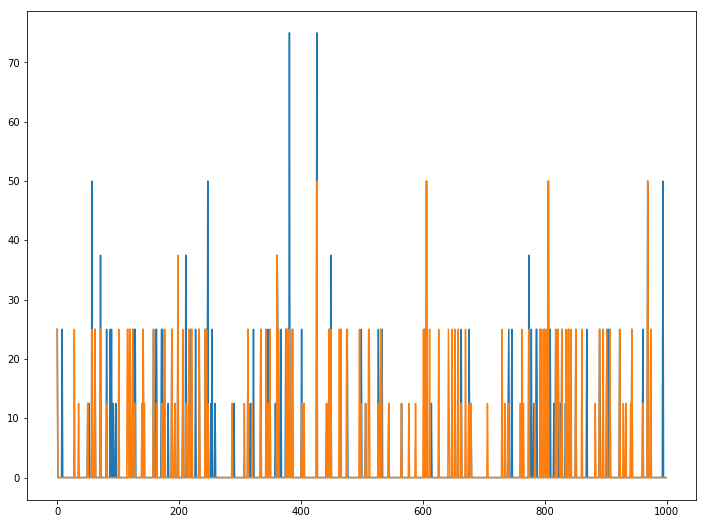

In [37]:
state_error_plot = [np.median(results[s]['state_error'])*100/grid_size**2 for s in results.keys()]
meas_error_plot = [np.median(results[s]['meas_error'])*100/grid_size**2 for s in results.keys()]

plt.figure(figsize=(12,9))
plt.plot(state_error_plot)
plt.plot(meas_error_plot)

scratch code

In [ ]:
# debug
if p >= 10:
    print('iteration:',iteration)
    print('p:',p)
    for m in range(num_neighbors):
        nghbr = neighbors[(i,j)][m]
        if int(xj[m]) == 0:
            prob = (node_data[(nghbr[0],nghbr[1])]['msg'][0] + \
                    node_data[(nghbr[0],nghbr[1])]['msg'][2])
        elif int(xj[m]) == 1:
            prob = node_data[(nghbr[0],nghbr[1])]['msg'][1]

        print(prob)

    print(node_data[(i,j)])
    raise Exception()
    
# debug
if any([el > 10 for el in node_data[(i,j)]['msg_next'].values()]):
    print(qi_list)
    print(qi_vals)
    print(normalization)
    print('k iteration:',iteration)
    print('id:',(i,j))
    print(node_data[(i,j)])
    raise Exception()